In [1]:
from fenics import *
import mshr
import numpy as np
import os
import scipy.io
from egfcore import *
from utils2Dpoisson import *
    
set_log_level(30)
%matplotlib widget

In [2]:
def sampleforcing2D(sigma, nSamples):
    """
    Sample nSamples random functions generated from a GP with squared-exp kernel with length scale parameter sigma using Chebfun.
    Ensure that a data1D.mat (mesh locations where the randomly generated chebfun function is sampled at) by initializing a Simulator class.
    """
    matlab_path = "/Applications/MATLAB_R2022a.app/bin/matlab"
    os.system(f"{matlab_path} -nodisplay -nosplash -nodesktop -r \"run('sample2D({int(sigma*10000)},{nSamples})'); exit;\" | tail -n +11")
    data = scipy.io.loadmat("dat2D.mat")
    forcing = data['F']
    return forcing

In [3]:
class Simulator:
    
    def __init__(self, meshDensity):
        # Define the domain and mesh for the solving the PDE.
        circle = mshr.Circle(Point(0.0,0.0), 1.0)
        self.mesh = mshr.generate_mesh(circle, meshDensity)        
        self.V = FunctionSpace(self.mesh, 'P', 2)
        
        # Define the function space and store the meshweights for computation.
        V = FunctionSpace(self.mesh,'P',1)
        u = TestFunction(V)
        temp = assemble(u*dx)
        self.meshweights = (temp.get_local()[vertex_to_dof_map(V)]).reshape(-1,1)
        
        mesh_dict = {"X": self.mesh.coordinates()}
        scipy.io.savemat("mesh2D.mat", mesh_dict)
        
        # Create variational form for the problem
        self.bc = self.boundaryConditions()
        u = TrialFunction(self.V)
        v = TestFunction(self.V)
        self.f = Function(V)
        self.param = Constant(0)
        self.d2v = dof_to_vertex_map(V)
        self.a = -dot(grad(u), grad(v))* dx
        self.L = self.f*v*dx
        self.u = Function(self.V)
        
    def boundaryConditions(self):
        """
        Define homogeneous Dirichlet Boundary conditions for the problem.
        """
        def boundary(x, on_boundary):
            return on_boundary
        
        u_D = Constant(0)
        bc = DirichletBC(self.V, u_D, boundary)
        
        return bc
    
    def solve(self, forcing, noise_level = None, param=None):
        """
        Given a (N_sensors x 1) forcing vector, solve the a 2D Poisson problem on a unit disc.
        """
        
        self.f.vector()[:] = forcing[self.d2v] # Instantiate the source term in the variational form by interpolating the sampled sourcing term.
        if param is not None:
            self.param.assign(param) # Define the parameter for the problem
        solve(self.a == self.L, self.u, self.bc) # Solve the variation form

        # Sample the solution at the nodes of the mesh.
        solution = self.u.compute_vertex_values(self.mesh)
        
        # As specified, add IID Gaussian white noise.
        if noise_level is not None:
            noise =  noise_level*np.random.normal(0,np.abs(solution.mean()),solution.shape)
            solution += noise
        
        return solution

# EGF model

In [4]:
%%time
add_noise = False
noise_level = 0.1
params = np.array([1.0])
verbose = False

meshDensity = 50
sigma = 0.2
nSamples = 2000
rank = 500

print(f"Method: Coefficient fit | meshDensity: {meshDensity}, sigma: {sigma}, nSamples: {nSamples}, rank: {rank}")
Sim = Simulator(meshDensity)

# Generate an forcing and output ensemble by simulating Poisson problem with FENICS.
forcing = sampleforcing2D(sigma, nSamples)
solution = np.zeros(forcing.shape)
for i in range(solution.shape[1]):
    if verbose:
        print("i = %d / %d"%(i+1, solution.shape[1]))
    if add_noise:
        solution[:,i] = Sim.solve(forcing[:,i], noise_level, params[0])
    else:
        solution[:,i] = Sim.solve(forcing[:,i], None, params[0])

model = EGF("coefficient-fit", params, rank, Sim.mesh, forcing, solution, None, None, None, None, verbose = verbose)

Method: Coefficient fit | meshDensity: 50, sigma: 0.2, nSamples: 2000, rank: 500
CPU times: user 52min 53s, sys: 10min 14s, total: 1h 3min 8s
Wall time: 40min 17s


Text(0.5, 0.98, '$G(x_1,x_2,0,0)$')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
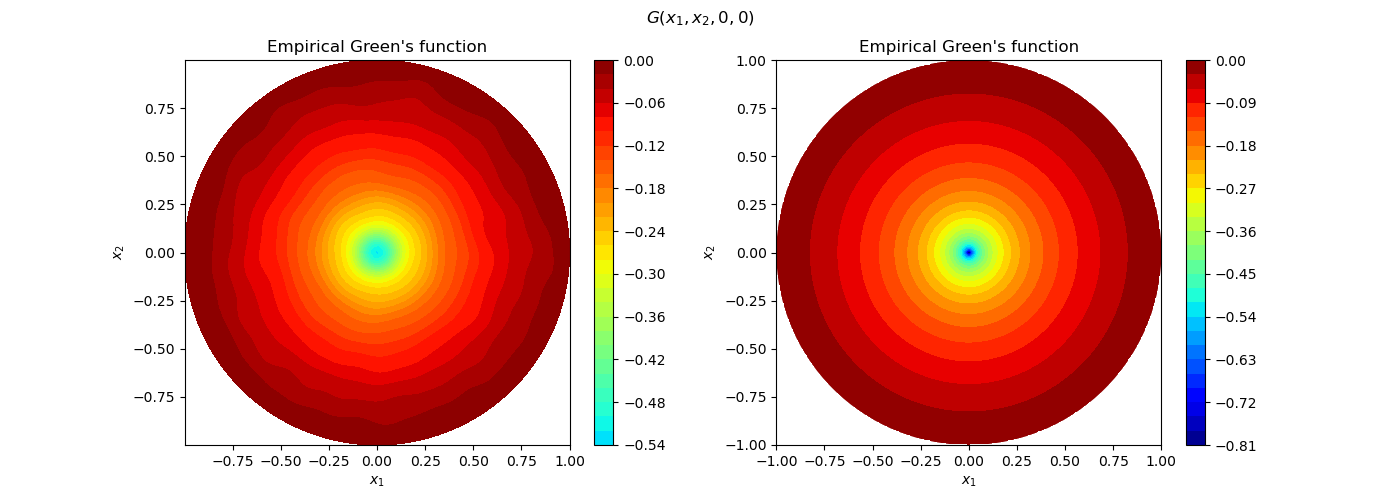

In [5]:
plotGxx00(model)
plt.suptitle(f"$G(x_1,x_2,0,0)$")

Text(0.5, 0.98, '$G(x_1,0,s_1,0)$')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
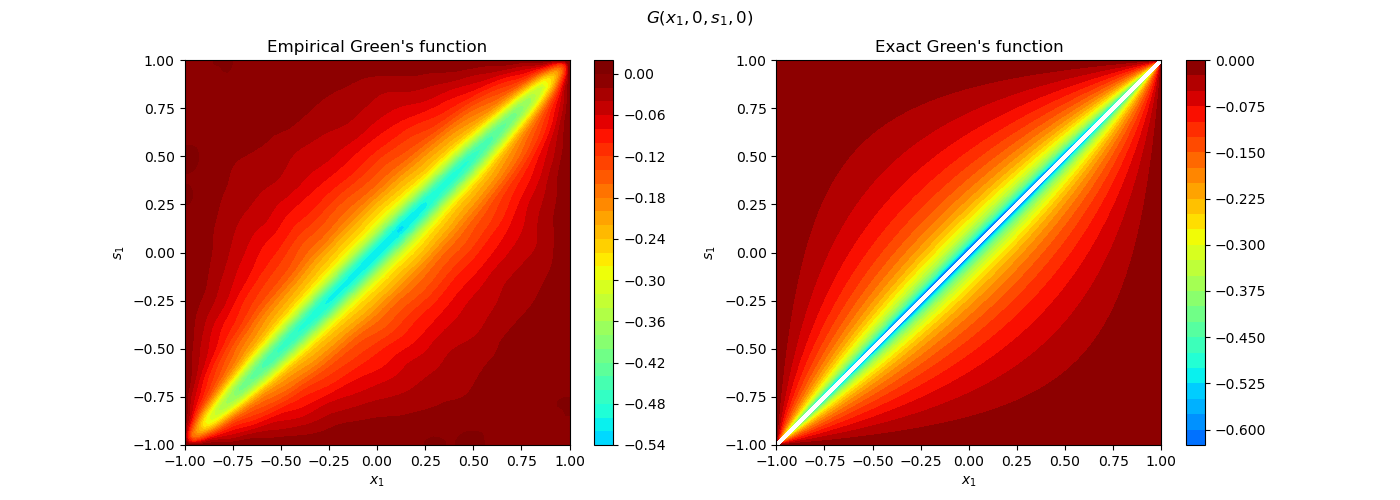

In [6]:
plotGx0s0(model)
plt.suptitle(f"$G(x_1,0,s_1,0)$")

In [ ]:
forcing = sampleforcing2D(sigma, nSamples)

Index in position 2 exceeds array bounds. Index must not exceed 1.

Error in sample2D (line 11)
        F(:,i) = f(X(:,1),X(:,2));

Error in run (line 91)
evalin('caller', strcat(script, ';'));
 


In [8]:
def computeEmpiricalError(model, Sim, sigma, nSamples, noise_level = None):
    seed = 1
    np.random.seed(1)

    # Generate an forcing and output ensemble for testing
    forcing = sampleforcing2D(sigma, nSamples)
    solution = np.zeros(forcing.shape)
    
    for i in range(nSamples):
        if noise_level is not None:
            solution[:,i] = Sim.solve(forcing[:,i], noise_level)
        else:
            solution[:,i] = Sim.solve(forcing[:,i])
    
    reconstruction = model.reconstruct_signal(forcing)
    
    error = np.zeros(nSamples)
    for i in range(nSamples):
        V = FunctionSpace(Sim.mesh, 'P', 1)
        d2v = dof_to_vertex_map(V)
        temp = Function(V)
        temp.vector()[:] = np.square(reconstruction[:,i] - solution[:,i])[d2v]
        num = assemble(temp*dx)
        temp.vector()[:] = np.square(solution[:,i])[d2v]
        den = assemble(temp*dx)
        
        error[i] = np.sqrt(num/den)
        
    return error

In [9]:
samples = 100 # Compute empirical error for 100 samples but on the same mesh

if add_noise:
    empError = computeEmpiricalError(model, Sim, sigma, samples, noise_level)
else:
    empError = computeEmpiricalError(model, Sim, sigma, samples)

print(f"Max error: {np.max(empError)}")
print(f"Mean error: {np.mean(empError)}")

Index in position 2 exceeds array bounds. Index must not exceed 1.

Error in sample2D (line 11)
        F(:,i) = f(X(:,1),X(:,2));

Error in run (line 91)
evalin('caller', strcat(script, ';'));
 


Max error: 0.0902629075620551
Mean error: 0.046987219837845935


In [10]:
%%time
add_noise = False
noise_level = 0.1
params = np.array([1.0])
verbose = False

meshDensity = 50
sigma = 0.2
rank = 500
nSamples = rank
    
print(f"Method: Randomized SVD | meshDensity: {meshDensity}, sigma: {sigma}, nSamples: {nSamples}, rank: {rank}")
Sim = Simulator(meshDensity)

# Generate an forcing and output ensemble by simulating Poisson problem with FENICS.
forcing = sampleforcing2D(sigma, nSamples)
solution = np.zeros(forcing.shape)
for i in range(solution.shape[1]):
    if verbose:
        print("i = %d / %d"%(i+1, solution.shape[1]))
    if add_noise:
        solution[:,i] = Sim.solve(forcing[:,i], noise_level, params[0])
    else:
        solution[:,i] = Sim.solve(forcing[:,i], None, params[0])

modelrandomized = EGF("randomized-svd", params, rank, Sim.mesh, forcing, solution, None, None, None, Sim, verbose = verbose)

Method: Randomized SVD | meshDensity: 50, sigma: 0.2, nSamples: 500, rank: 500
CPU times: user 6min 6s, sys: 2min 23s, total: 8min 29s
Wall time: 3min 11s


Text(0.5, 0.98, '$G(x_1,x_2,0,0)$')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
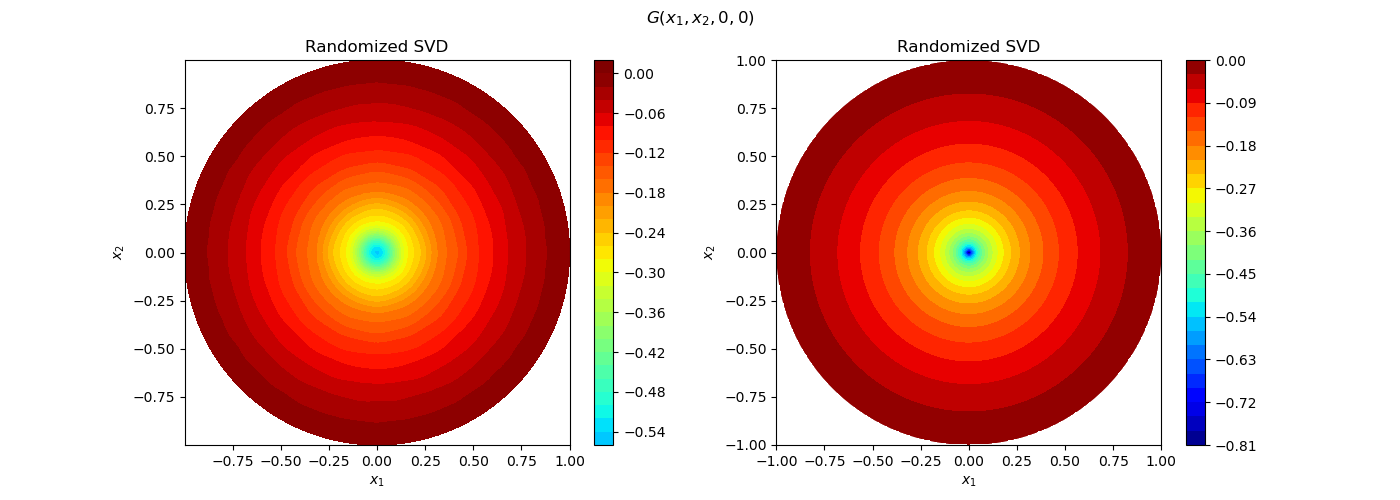

In [14]:
plotGxx00(modelrandomized)
plt.suptitle(f"$G(x_1,x_2,0,0)$")

Text(0.5, 0.98, '$G(x_1,0,s_1,0)$')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
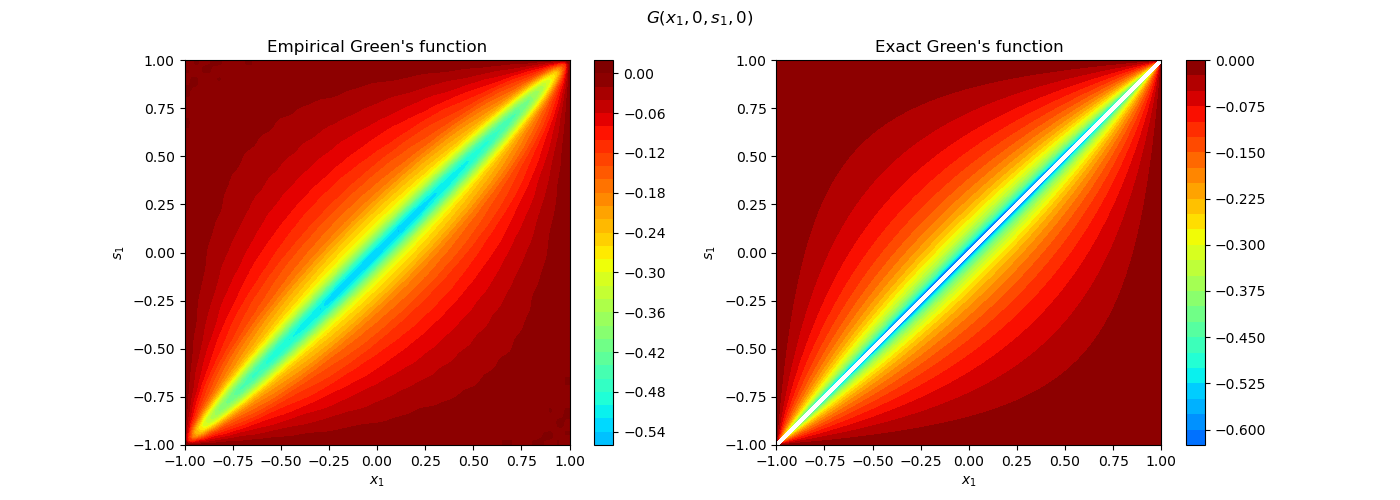

In [15]:
plotGx0s0(modelrandomized)
plt.suptitle(f"$G(x_1,0,s_1,0)$")

In [16]:
samples = 100 # Compute empirical error for 100 samples but on the same mesh

if add_noise:
    empError = computeEmpiricalError(modelrandomized, Sim, sigma, samples, noise_level)
else:
    empError = computeEmpiricalError(modelrandomized, Sim, sigma, samples)

print(f"Max error: {np.max(empError)}")
print(f"Mean error: {np.mean(empError)}")

Max error: 0.00772533592950516
Mean error: 0.0037568361969394443


In [17]:
def plotGpaper(model, modelr):
    vmin = -0.81
    vmax = 0.0
    G = reconstructGxx00(model)
    
    # print(G)
    V = FunctionSpace(model.mesh, 'P', 1)
    d2v = dof_to_vertex_map(V)
    u = Function(V)
    temp = np.squeeze(G)
    u.vector()[:] = temp[d2v]
    
    plt.figure(figsize = (15,9))
    plt.tight_layout()
    plt.subplots_adjust(left = 0.05, wspace=0.3, hspace=0.3)
    plt.subplot(231)
    
    levels = np.linspace(vmin, vmax, 30)
    p = plot(u, levels = levels, cmap = 'jet', vmin = vmin, vmax = vmax)
    
    plt.colorbar(p,fraction=0.046, pad=0.04, ticks = np.linspace(vmin, vmax, 10))
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$', rotation='horizontal', labelpad=5)
    plt.xticks([-1.0,-0.5,0,0.5,1.0])
    plt.yticks([-1.0,-0.5,0,0.5,1.0])
    plt.title("POD")
    plt.title('A',loc ='left', weight = 'bold', size = 12)
    

    G = reconstructGxx00(modelr)
    
    # print(G)
    V = FunctionSpace(modelr.mesh, 'P', 1)
    d2v = dof_to_vertex_map(V)
    u = Function(V)
    temp = np.squeeze(G)
    u.vector()[:] = temp[d2v]
    
    plt.subplot(232)
    
    levels = np.linspace(vmin, vmax, 30)
    p = plot(u, levels = levels, cmap = 'jet', vmin = vmin, vmax = vmax) # 
    c = plt.colorbar(p,fraction=0.046, pad=0.04, ticks = np.linspace(vmin, vmax, 10))
    
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$', rotation='horizontal', labelpad=5)
    plt.xticks([-1.0,-0.5,0,0.5,1.0])
    plt.yticks([-1.0,-0.5,0,0.5,1.0])
    plt.title("Randomized SVD")
    plt.title('B',loc ='left', weight = 'bold', size = 12)
    # Compute exact G
    domain = np.linspace(-1,1,301)
    
    x, s = np.meshgrid(domain,domain)
    G_exact = np.zeros(np.shape(x))
    for i in range(x.shape[0]):
        for j in range(x.shape[0]):
            xx, ss = x[i,j], s[i,j]
            if xx**2 + ss**2 <= 1.0 and (xx != 0 or ss != 0):
                G_exact[i,j] = (1/(4*pi))* np.log(xx**2 + ss**2)
            else:
                G_exact[i,j] = np.nan
            
    plt.subplot(233)
    plt.gca().set_aspect('equal', adjustable = 'box')
    surf = plt.contourf(x, s, G_exact, levels = 30, cmap = 'jet', vmin = vmin, vmax = vmax)
    circ = patches.Circle((0, 0), 1.0, transform = plt.gca().transData, facecolor = 'none')
    plt.gca().add_patch(circ)
    for col in surf.collections:
        col.set_clip_path(circ)

    plt.colorbar(surf,fraction=0.046, pad=0.04)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$', rotation='horizontal', labelpad=5)
    plt.xticks([-1.0,-0.5,0,0.5,1.0])
    plt.yticks([-1.0,-0.5,0,0.5,1.0])
    plt.title("Exact Green's function")
    plt.title('C',loc ='left', weight = 'bold', size = 12)
    
    
    samples = 100
    vmin = -0.81
    vmax = 0.09
    x, s = np.meshgrid(np.linspace(-1, 1, num = samples), np.linspace(-1, 1, num = samples))
    
    plt.subplot(234)
    G, G_true = reconstructGx0s0(model, samples)
    
    levels = np.linspace(vmin, vmax, 30)
    surf = plt.contourf(x, s, G, levels = levels, cmap = 'jet', vmin = vmin, vmax = vmax)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.colorbar(surf, fraction=0.046, pad=0.04, ticks = np.linspace(vmin, vmax, 11))
    plt.xlabel('$x_1$')
    plt.ylabel('$s_1$', rotation='horizontal', labelpad=5)
    plt.xticks([-1.0,-0.5,0,0.5,1.0])
    plt.yticks([-1.0,-0.5,0,0.5,1.0])
    plt.title("POD")
    plt.title('D',loc ='left', weight = 'bold', size = 12)
 
    plt.subplot(235)
    
    G, _ = reconstructGx0s0(modelr, samples)
    levels = np.linspace(vmin, vmax, 30)
    surf = plt.contourf(x, s, G, levels = levels, cmap = 'jet', vmin = vmin, vmax = vmax)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.colorbar(surf, fraction=0.046, pad=0.04, ticks = np.linspace(vmin, vmax, 11))
    plt.xlabel('$x_1$')
    plt.ylabel('$s_1$', rotation='horizontal', labelpad=5)
    plt.xticks([-1.0,-0.5,0,0.5,1.0])
    plt.yticks([-1.0,-0.5,0,0.5,1.0])
    plt.title("Randomized SVD")
    plt.title('E',loc ='left', weight = 'bold', size = 12)
    
    plt.subplot(236)
    levels = np.linspace(vmin, vmax, 30)
    surf = plt.contourf(x, s, G_true, levels = levels, cmap = 'jet', vmin = vmin, vmax = vmax)
    plt.gca().set_aspect('equal', adjustable='box')
    # surf = plt.imshow(G, interpolation='lanczos', cmap='jet', extent=[-1,1,-1,1], vmin = -0.8, vmax=0)
    plt.colorbar(surf, fraction=0.046, pad=0.04, ticks = np.linspace(vmin, vmax, 11))
    plt.xlabel('$x_1$')
    plt.ylabel('$s_1$', rotation='horizontal', labelpad=5)
    plt.xticks([-1.0,-0.5,0,0.5,1.0])
    plt.yticks([-1.0,-0.5,0,0.5,1.0])
    plt.title("Exact Green's function")
    plt.title('F',loc ='left', weight = 'bold', size = 12)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
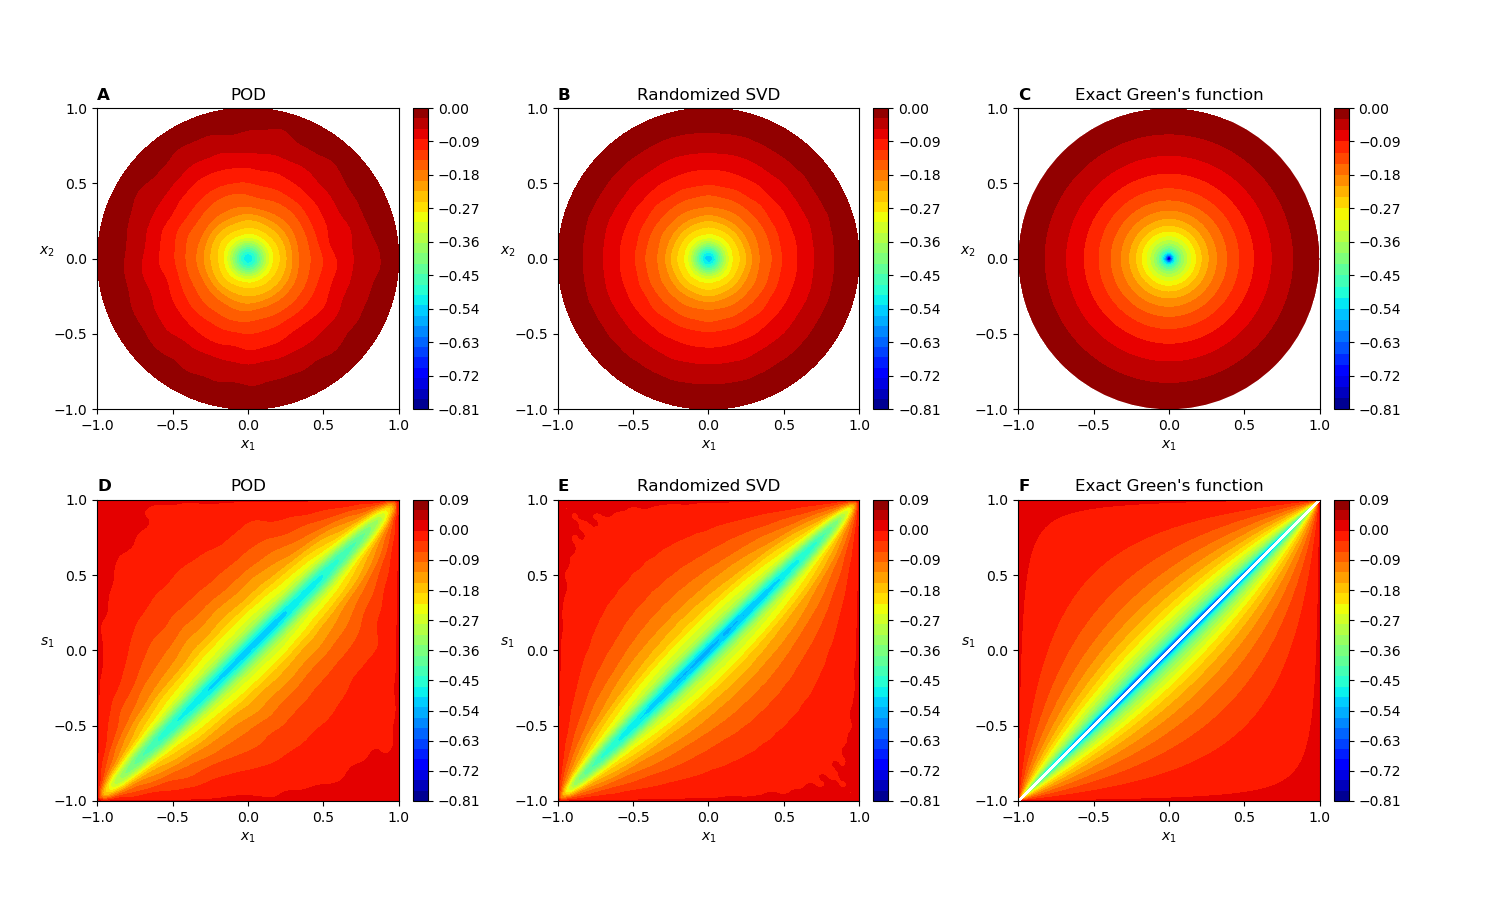

In [18]:
plotGpaper(model,modelrandomized)